In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import numpy as np

# 🔧 Fonction utilitaire pour créer un BallTree et compter les voisins
def count_neighbors(tree, points, radius_m):
    # radius_m converted to radians
    radius = radius_m / 6371000  # Earth radius in meters
    counts = tree.query_radius(points, r=radius, count_only=True)
    return counts

# 1. Charger les données
df = pd.read_csv("./db/Bordeaux.csv", sep=";", encoding="utf-8", skiprows=lambda i: i > 0 and np.random.rand() > 0.2)
print("c'estgood1")

commerces = pd.read_csv("./db/fi_etabl_p.csv",  sep=";", encoding="utf-8", skiprows=lambda i: i > 0 and np.random.rand() > 0.2)
print("c'estgood2")

commerces = commerces.dropna(subset=["Geo Point"]).reset_index(drop=True)
# Vérifier que la colonne 'Geo Point' existe et n'a pas de valeurs manquantes
if 'Geo Point' in commerces.columns:
    geo_split = commerces['Geo Point'].str.split(",", expand=True)
    if geo_split.shape[1] == 2:
        commerces['latitude'] = geo_split[0].str.strip().astype(float)
        commerces['longitude'] = geo_split[1].str.strip().astype(float)
    else:
        raise ValueError("La colonne 'Geo Point' ne contient pas de coordonnées valides.")
else:
    raise KeyError("La colonne 'Geo Point' est absente du DataFrame.")
commerces['lat_rad'] = np.deg2rad(commerces['latitude'])
commerces['lon_rad'] = np.deg2rad(commerces['longitude'])
logements_coords = commerces[['lat_rad', 'lon_rad']].to_numpy()

ecoles = pd.read_csv("./db/educ_bordeaux.csv", sep=";", encoding="utf-8", skiprows=lambda i: i > 0 and np.random.rand() > 0.2)
print("c'estgood3")
# 🔎 Vérifier que les colonnes latitude/longitude existent et sont bien nommées
print("Colonnes commerces :", commerces.columns)
print("Colonnes ecoles :", ecoles.columns)

# 🌍 Convertir en radians pour BallTree
df = df.dropna(subset=["valeur_fonciere", "latitude", "longitude"]).reset_index(drop=True)
df['lat_rad'] = np.deg2rad(df['latitude'])
df['lon_rad'] = np.deg2rad(df['longitude'])
logements_coords = df[['lat_rad', 'lon_rad']].to_numpy()

commerces['lat_rad'] = np.deg2rad(commerces['latitude'])
commerces['lon_rad'] = np.deg2rad(commerces['longitude'])
commerces_coords = commerces[['lat_rad', 'lon_rad']].to_numpy()

ecoles['lat_rad'] = np.deg2rad(ecoles['latitude'])
ecoles['lon_rad'] = np.deg2rad(ecoles['longitude'])
ecoles_coords = ecoles[['lat_rad', 'lon_rad']].to_numpy()

# 🔧 Création des BallTree
tree_commerces = BallTree(commerces_coords, metric='haversine')
tree_ecoles = BallTree(ecoles_coords, metric='haversine')

c'estgood1
c'estgood2
c'estgood3
Colonnes commerces : Index(['Geo Point', 'Geo Shape', 'gid', 'geom_o', 'geom_err', 'ident',
       'adresse', 'insee', 'raison_sociale', 'enseigne', 'sigle', 'telephone',
       'date_etablissement', 'SECTION', 'email', 'url', 'forme_juridique_agg',
       'forme_juridique', 'statut', 'date_entreprise', 'naf', 'annee_effectif',
       'tranche_effectif', 'cdate', 'mdate', 'CODESECTION', 'nom',
       'groupe_naf', 'section_naf', 'zonage_economique', 'acteur_economique',
       'activite_commerce', 'origine', 'latitude', 'longitude', 'lat_rad',
       'lon_rad'],
      dtype='object')
Colonnes ecoles : Index(['Identifiant_de_l_etablissement', 'Nom_etablissement',
       'Type_etablissement', 'Statut_public_prive', 'Adresse_1', 'Adresse_2',
       'Adresse_3', 'Code_postal', 'Code_commune', 'Nom_commune',
       'Code_departement', 'Code_academie', 'Code_region', 'Ecole_maternelle',
       'Ecole_elementaire', 'Voie_generale', 'Voie_technologique',
      

In [ ]:
print("Calcul des features spatiales...")
df['n_commerces_1000m'] = count_neighbors(tree_commerces, logements_coords, 1000)
df['n_ecoles_1000m'] = count_neighbors(tree_ecoles, logements_coords, 1000)

# 2. Encodage one-hot pour code_type_local et type_local
df = pd.get_dummies(df, columns=["code_type_local", "type_local"], drop_first=True)

# 3. Réduire la taille de la base pour tests rapides (ex: 5%)
df = df.sample(frac=0.10, random_state=42).reset_index(drop=True)

# 4. Préparation des features finales
X = df[["surface_reelle_bati", "nombre_pieces_principales", "surface_terrain",
        "code_postal", "n_commerces_1000m", "n_ecoles_1000m"] +
       [col for col in df.columns if col.startswith("code_type_local_") or col.startswith("type_local_")]].fillna(0)

y = df["valeur_fonciere"]

# 5. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Calcul des features spatiales...


MAE (Mean Absolute Error) - Test : 782444.5622806353
MAE as percentage of mean valeur_fonciere: 86.92%
MAE (Mean Absolute Error) - Train : 412211.36834496463
R² score : -0.3188118034032619


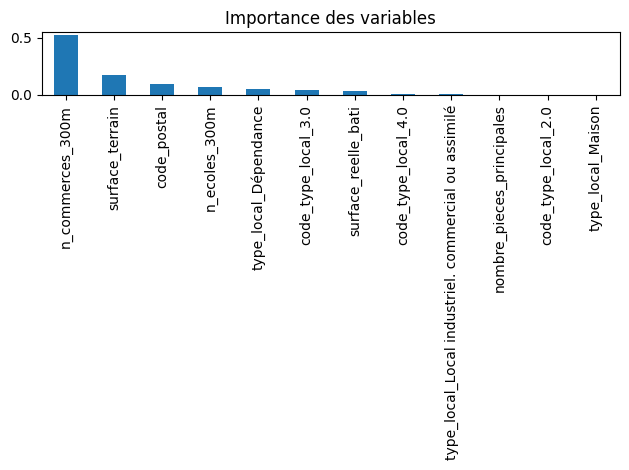

In [15]:
model = RandomForestRegressor(n_estimators=200)
model.fit(X_train, y_train)

# 7. Prédictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# 8. Évaluation
mae_test = mean_absolute_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE (Mean Absolute Error) - Test : {mae_test}")
min_abs_error_pct = (mae_test / y_test.mean()) * 100
print(f"MAE as percentage of mean valeur_fonciere: {min_abs_error_pct:.2f}%")
print(f"MAE (Mean Absolute Error) - Train : {mae_train}")
print(f"R² score : {r2}")


# 9. Importance des variables
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind="bar", title="Importance des variables")
plt.tight_layout()
plt.show()